In [1]:
import numpy as np
import cv2
import h5py
import time

import matplotlib.pyplot as plt
from tqdm.notebook import trange

# Loading simulation data

In [2]:
f = h5py.File("/storage/rando/data/nose_data.mat")
reading_time = time.time()
nose_data = np.asarray(f["nose"])
reading_time = time.time() - reading_time
print("[--] Data read in {}s!".format(round(reading_time, 4)))
f.close()

[--] Data read in 47.627s!


In [3]:
f = h5py.File("/storage/rando/data/ground_data.mat")
reading_time = time.time()
ground_data = np.asarray(f["ground"])
reading_time = time.time() - reading_time
print("[--] Data read in {}s!".format(round(reading_time, 4)))
f.close()

[--] Data read in 48.6786s!


# Resizing data and treshold

In [4]:
tresh = 3e-6

In [5]:
nose_resized = []
for i in trange(nose_data.shape[0]):
    arr = np.zeros((61,361))
    arr[15:46,60:181] = cv2.resize(nose_data[i], dsize=(121,31))
    nose_resized.append(arr)

nose_resized = np.array(nose_resized) > tresh

  0%|          | 0/2600 [00:00<?, ?it/s]

In [6]:
ground_resized = []
for i in trange(ground_data.shape[0]):
    arr = np.zeros((61,361))
    arr[15:46,60:181] = cv2.resize(ground_data[i], dsize=(121,31))
    ground_resized.append(arr)

ground_resized = np.array(ground_resized) > tresh

  0%|          | 0/2600 [00:00<?, ?it/s]

# Overwriting Simulation

In [7]:
import sys
sys.path.append('../..')
from src.pomdp import *

In [21]:
class RealSimulation(Simulation):
    def __init__(self, model: Model) -> None:
        self.iter = None
        super().__init__(model)


    def initialize_simulation(self, start_state: int | None = None) -> int:
        self.iter = 0
        return super().initialize_simulation(start_state)


    def run_action(self, a: int) -> tuple[int | float, int]:
        r,_ = super().run_action(a)

        x,y = self.model.get_coords(self.agent_state)
        o = 1 if (nose_resized if a == 5 else ground_resized)[self.iter, x, y] else 0

        self.iter += 1
        return (r,o)

# Gather model and VF

In [11]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')
vf = ValueFunction.load_from_file('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/ValueFunctions/run-3-VF.gzip', model)

# Simulation

In [22]:
a = Agent(model, vf)

In [28]:
hist = a.simulate(RealSimulation(model))

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 35.678043
	- Steps: 440
	- Total rewards: 1.0
	- End state: s_30_60


# Plot Result

In [24]:
from viz_functions import plot_steps

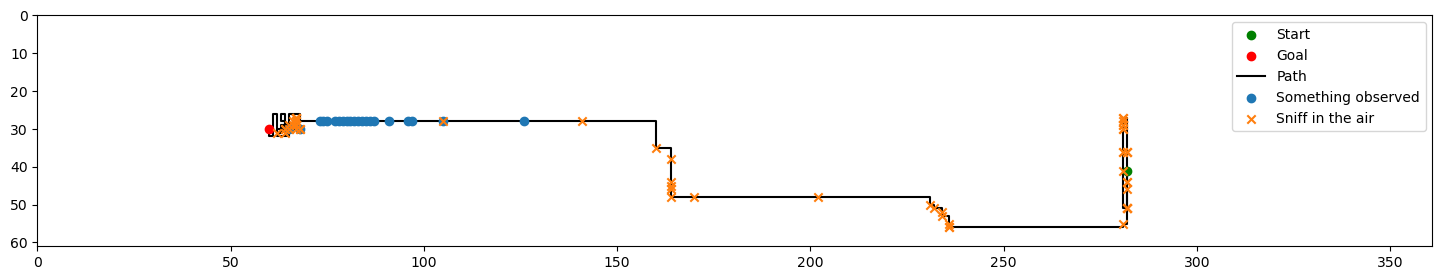

In [29]:
plot_steps(hist)